# RNN

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.


# 시계열 예측하기

In [38]:
# batch_size로 요청한 만큼 n_steps길이의 여러 시계열을 만든다.
# 각 시계열에는 타임스텝마다 하나의 값만 있다. 
# 이 함수는 [배치크기, 타임스텝수, 1] 크기의 넘파이 배열을 반환한다. 즉, 타임스텝 길이의 벡터를 배치크기만큼 만든다.
# 각 시계열은 진폭이 같고 진동 수와 위상이 랜덤한 두 개의 사인 곡선을 더하고 약간의 잡음을 추가한다.
def generate_time_series(batch_size, n_steps):
    # (4, batch_size, 1) 크기의 0~1 사이의 임의의 숫자가 적인 array를 리턴함
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    # np.linspace(구간 시작점, 구간 끝점, 구간 내 숫자 개수)
    time = np.linspace(0,1,n_steps)
    series = 0.5 * np.sin((time-offsets1) * (freq1 * 10 + 10)) # 사인곡선 1
    series += 0.2 * np.sin((time-offsets2) * (freq2 * 20 + 20)) # + 사인곡선 2
    series += 0.1 * (np.random.rand(batch_size, n_steps)-0.5) # + 잡음
    return series[..., np.newaxis].astype(np.float32)
# 시계열의 입력특성은 보통 [배치크기, 타임스텝수, 차원 수] 로 전달된다.

In [54]:
np.random.seed(42)


n_steps = 50
series = generate_time_series(10000, n_steps+1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, n_steps], series[9000:, -1]

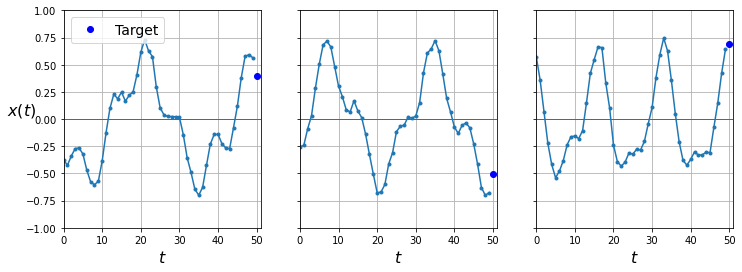

In [55]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

# 기준 성능
RNN을 시작하기 전에 기준 성능을 몇개 준비하는 것이 좋다. 그렇지 않은면 실제 시본 모델모다 성능일 나쁠 때도 잘 작동한다고 생각할 수 있다. 예를 들어 가장 간단한 방법은 각 시계열의 마지막 값을 그대로 예측하는 것이다. 이를 naive forecasting이라고 한다. 

가끔은 이 성능을 뛰어넘는게 굉장히 어렵다. 이 경우 MSE는 0.020 이다.

In [58]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

또 간단한 방법은 완전 연결 네트워크를 사용하는 것이다. 이 네트워크는 입력마다 1차원 특성배열을 기대하기 때문에 Flatten 층을 추가해야한다. 